In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

import os
%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

In [2]:
m3dict = {

    '1B': {'histdir': '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-bc370_hist/', 
           'futdir': '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/ssp370/u-ce417_ssp370/',
          'wts': 'UKESMm1'},
    '1BM2': {'histdir': '/gpfs/data/greenocean2/software/products/windsFromComponents/UKESM_extra_endmembers/member02_bc179', 
           'futdir': '/gpfs/data/greenocean2/software/products/windsFromComponents/UKESM_extra_endmembers/member02_be647',  
            'wts': 'UKESMm2'},
    '1BM3': {'histdir': '/gpfs/data/greenocean2/software/products/windsFromComponents/UKESM_extra_endmembers/member03_bc292',  
           'futdir': '/gpfs/data/greenocean2/software/products/windsFromComponents/UKESM_extra_endmembers/member03_be690', 
            'wts': 'UKESMm3'},
    '1BEM': {'histdir': '', 
           'futdir': '', 
            'wts': 'UKESMEM'},
    
    
    
    '2B': {'histdir': '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/hist/u-cj198_hist_1950start1950ozone/', 
           'futdir': '/gpfs/data/greenocean/software/resources/MetOffice/fixed_ozone/ssp370/u-cj881_ssp370_1950start1950ozone/',
          'wts': 'UKESM-NOm1'},
    '2BM2': {'histdir': '/gpfs/data/greenocean2/software/products/windsFromComponents/UKESM_extra_endmembers/member02_cq935', 
           'futdir': '/gpfs/data/greenocean2/software/products/windsFromComponents/UKESM_extra_endmembers/member02_cy233',  
            'wts': 'UKESM-NOm2'},
    '2BM3': {'histdir': '/gpfs/data/greenocean2/software/products/windsFromComponents/UKESM_extra_endmembers/member03_cq937',  
           'futdir': '/gpfs/data/greenocean2/software/products/windsFromComponents/UKESM_extra_endmembers/member03_dl580/', 
            'wts': 'UKESM-NOm3'},
    '2BEM': {'histdir': '', 
           'futdir': '', 
            'wts': 'UKESMEM-NO'},
    
}

## check sizes of wind files

In [3]:
import os

def wind_size(base_dir = "/path/to/search"):
    # Set the base directory where to search for folders containing 'wind'

    # Initialize variables
    files = [f for f in os.listdir(base_dir)
             if os.path.isfile(os.path.join(base_dir, f)) and 'wind' in f]

    # Initialize with None so we can handle empty cases
    largest_file = None
    smallest_file = None

    for f in files:
        path = os.path.join(base_dir, f)
        size = os.path.getsize(path)

        if largest_file is None or size > largest_file[1]:
            largest_file = (f, size)
        if smallest_file is None or size < smallest_file[1]:
            smallest_file = (f, size)

    if largest_file and smallest_file:
        print(f"Largest file: {largest_file[0]} ({largest_file[1]} bytes)")
        print(f"Smallest file: {smallest_file[0]} ({smallest_file[1]} bytes)")
    else:
        print("No files containing 'wind' found in the directory.")
    
nors = ['1B','1BM2','1BM3','2B','2BM2','2BM3',]

def slp_size(base_dir = "/path/to/search"):
    # Set the base directory where to search for folders containing 'wind'

    # Initialize variables
    files = [f for f in os.listdir(base_dir)
             if os.path.isfile(os.path.join(base_dir, f)) and 'slp' in f]

    # Initialize with None so we can handle empty cases
    largest_file = None
    smallest_file = None

    for f in files:
        path = os.path.join(base_dir, f)
        size = os.path.getsize(path)

        if largest_file is None or size > largest_file[1]:
            largest_file = (f, size)
        if smallest_file is None or size < smallest_file[1]:
            smallest_file = (f, size)

    if largest_file and smallest_file:
        print(f"Largest file slp: {largest_file[0]} ({largest_file[1]} bytes)")
        print(f"Smallest file slp: {smallest_file[0]} ({smallest_file[1]} bytes)")
    else:
        print("No files containing 'wind' found in the directory.")
    

In [4]:
ex = False
if ex:
    nors = ['1B','1BM2','1BM3','2B','2BM2','2BM3',]


    for nor in nors:
        print(nor)
        tdir = m3dict[nor]['histdir']
        wind_size(tdir)
        slp_size(tdir)
        tdir = m3dict[nor]['futdir']
        wind_size(tdir)
        slp_size(tdir)



In [5]:
if ex: 
    nors = ['1B','1BM2','1BM3','2B','2BM2','2BM3',]

    for nor in nors:
        print(nor)
        for yr in range(1980,2021):

            if yr < 2015:
                tdir = m3dict[nor]['histdir']
            else:
                tdir = m3dict[nor]['futdir']

            w01s = glob.glob(f'{tdir}/*_slp_y{yr}m01.nc')[0]
            w01s_fs = os.path.getsize(w01s)
            w01 = xr.open_dataset(w01s)
            w01c = len(w01.time_counter)
            if ((w01c != 360) | (w01s_fs < 26000000)):
                print(f'{w01s}--- time counter size {w01c}, filesize {w01s_fs}')

            w04s = glob.glob(f'{tdir}/*_slp_y{yr}m04.nc')[0]
            w04s_fs = os.path.getsize(w04s)
            w04 = xr.open_dataset(w04s)
            w04c = len(w04.time_counter)
            if ((w04c != 360) | (w04s_fs < 26000000)):
                print(f'{w04s}--- time counter size {w04c}, filesize {w04s_fs}')

            w07s = glob.glob(f'{tdir}/*_slp_y{yr}m07.nc')[0]
            w07s_fs = os.path.getsize(w07s)
            w07 = xr.open_dataset(w07s)
            w07c = len(w07.time_counter)
            if ((w07c != 360) | (w07s_fs < 26000000)):
                print(f'{w07s}--- time counter size {w07c}, filesize {w07s_fs}')

            w10s = glob.glob(f'{tdir}/*_slp_y{yr}m10.nc')[0]
            w10s_fs = os.path.getsize(w10s)
            w10 = xr.open_dataset(w10s)
            w10c = len(w10.time_counter)
            if ((w10c != 360) | (w10s_fs < 26000000)):
                print(f'{w10s}--- time counter size {w10c}, filesize {w10s_fs}')
                
    nors = ['1B','1BM2','1BM3','2B','2BM2','2BM3',]

    for nor in nors:
        for yr in range(1980,2020):

            if yr < 2015:
                tdir = m3dict[nor]['histdir']
            else:
                tdir = m3dict[nor]['futdir']

            w1 = xr.open_dataset(glob.glob(f'{tdir}/*_wind_y{yr}m01.nc')[0])
            w4 = xr.open_dataset(glob.glob(f'{tdir}/*_wind_y{yr}m04.nc')[0])
            w7 = xr.open_dataset(glob.glob(f'{tdir}/*_wind_y{yr}m07.nc')[0])
            w10 = xr.open_dataset(glob.glob(f'{tdir}/*_wind_y{yr}m10.nc')[0])

            w1c = len(w1.time_counter)
            w4c = len(w4.time_counter)
            w7c = len(w7.time_counter)
            w10c = len(w10.time_counter)

            if ((w1c != 360) | (w4c != 360) | (w7c != 360) | (w10c != 360)):

                print(f'{nor} {yr} {w1c} {w4c} {w7c} {w10c}')

## this is actually calculated in slink-check-files.py, 
    
    note that the interpolation is wrong here, should be np.interp(-40, ... corrected in script

In [6]:
def get_SAM(nor):
            
         
    time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
    
    sam40 = np.zeros(492)
    sam65 = np.zeros(492)
    ind = 0
    for yr in range(1980,2021):
        print(yr)

        if yr < 2015:
            tdir = m3dict[nor]['histdir']
        else:
            tdir = m3dict[nor]['futdir']


        w1 = xr.open_dataset(glob.glob(f'{tdir}/*_slp_y{yr}m01.nc')[0])
        w4 = xr.open_dataset(glob.glob(f'{tdir}/*_slp_y{yr}m04.nc')[0])
        w7 = xr.open_dataset(glob.glob(f'{tdir}/*_slp_y{yr}m07.nc')[0])
        w10 = xr.open_dataset(glob.glob(f'{tdir}/*_slp_y{yr}m10.nc')[0])

        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m1_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m2_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m3_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m4_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m5_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m6_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m7_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m8_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m9_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m10_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m11_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m12_65f = np.interp(-65, xp, fp)

        ##
        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m1_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m2_40f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m3_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m4_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m5_40f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m6_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m7_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m8_40f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m9_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m10_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m11_40f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m12_40f = np.interp(-65, xp, fp)

        yr40 = np.array([m1_40f, m2_40f, m3_40f, m4_40f, m5_40f, m6_40f, m7_40f, m8_40f, m9_40f, m10_40f, m11_40f, m12_40f])
        yr65 = np.array([m1_65f, m2_65f, m3_65f, m4_65f, m5_65f, m6_65f, m7_65f, m8_65f, m9_65f, m10_65f, m11_65f, m12_65f])
        sam40[ind:ind+12] = yr40/100
        sam65[ind:ind+12] = yr65/100
        ind = ind+12


    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    wts = m3dict[nor]['wts']
    data.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{wts}/SLP.nc')
    
    print(f'UKESM {nor} done')

## get out ensemble means

In [7]:
ex = False

if ex:
            
         
    time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
    
    sam40 = np.zeros(492)
    sam65 = np.zeros(492)
    ind = 0
    for yr in range(1980,2021):
        print(yr)

        if yr < 2015:
            tdir1 = m3dict['1B']['histdir']
            tdir2 = m3dict['1BM2']['histdir']
            tdir3 = m3dict['1BM3']['histdir']
        else:
            tdir1 = m3dict['1B']['futdir']
            tdir2 = m3dict['1BM2']['futdir']
            tdir3 = m3dict['1BM3']['futdir']


        w1a = xr.open_dataset(glob.glob(f'{tdir1}/*_slp_y{yr}m01.nc')[0])
        w1b = xr.open_dataset(glob.glob(f'{tdir2}/*_slp_y{yr}m01.nc')[0])
        w1c = xr.open_dataset(glob.glob(f'{tdir3}/*_slp_y{yr}m01.nc')[0])
        w1 = (w1a + w1b + w1c)/3

        w4a = xr.open_dataset(glob.glob(f'{tdir1}/*_slp_y{yr}m04.nc')[0])
        w4b = xr.open_dataset(glob.glob(f'{tdir2}/*_slp_y{yr}m04.nc')[0])
        w4c = xr.open_dataset(glob.glob(f'{tdir3}/*_slp_y{yr}m04.nc')[0])
        w4 = (w4a + w4b + w4c)/3

        w7a = xr.open_dataset(glob.glob(f'{tdir1}/*_slp_y{yr}m07.nc')[0])
        w7b = xr.open_dataset(glob.glob(f'{tdir2}/*_slp_y{yr}m07.nc')[0])
        w7c = xr.open_dataset(glob.glob(f'{tdir3}/*_slp_y{yr}m07.nc')[0])
        w7 = (w7a + w7b + w7c)/3 

        w10a = xr.open_dataset(glob.glob(f'{tdir1}/*_slp_y{yr}m10.nc')[0])
        w10b = xr.open_dataset(glob.glob(f'{tdir2}/*_slp_y{yr}m10.nc')[0])
        w10c = xr.open_dataset(glob.glob(f'{tdir3}/*_slp_y{yr}m10.nc')[0])
        w10 = (w10a + w10b + w10c)/3 

        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m1_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m2_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m3_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m4_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m5_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m6_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m7_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m8_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m9_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m10_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m11_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m12_65f = np.interp(-65, xp, fp)

        ##
        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m1_40f = np.interp(-40, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m2_40f = np.interp(-40, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m3_40f = np.interp(-40, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m4_40f = np.interp(-40, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m5_40f = np.interp(-40, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m6_40f = np.interp(-40, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m7_40f = np.interp(-40, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m8_40f = np.interp(-40, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m9_40f = np.interp(-40, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m10_40f = np.interp(-40, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m11_40f = np.interp(-40, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m12_40f = np.interp(-40, xp, fp)

        yr40 = np.array([m1_40f, m2_40f, m3_40f, m4_40f, m5_40f, m6_40f, m7_40f, m8_40f, m9_40f, m10_40f, m11_40f, m12_40f])
        yr65 = np.array([m1_65f, m2_65f, m3_65f, m4_65f, m5_65f, m6_65f, m7_65f, m8_65f, m9_65f, m10_65f, m11_65f, m12_65f])
        sam40[ind:ind+12] = yr40/100
        sam65[ind:ind+12] = yr65/100
        ind = ind+12


    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    #wts = m3dict['UKESMEM']['wts']
    data.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMEM/SLP.nc')

    print(f'UKESMEM done')

if ex:
            
    time = pd.date_range(start="1980-01-01", end="2020-12-31", freq='M')
    
    sam40 = np.zeros(492)
    sam65 = np.zeros(492)
    ind = 0
    for yr in range(1980,2021):
        print(yr)

        if yr < 2015:
            tdir1 = m3dict['2B']['histdir']
            tdir2 = m3dict['2BM2']['histdir']
            tdir3 = m3dict['2BM3']['histdir']
        else:
            tdir1 = m3dict['2B']['futdir']
            tdir2 = m3dict['2BM2']['futdir']
            tdir3 = m3dict['2BM3']['futdir']


        w1a = xr.open_dataset(glob.glob(f'{tdir1}/*_slp_y{yr}m01.nc')[0])
        w1b = xr.open_dataset(glob.glob(f'{tdir2}/*_slp_y{yr}m01.nc')[0])
        w1c = xr.open_dataset(glob.glob(f'{tdir3}/*_slp_y{yr}m01.nc')[0])
        w1 = (w1a + w1b + w1c)/3

        w4a = xr.open_dataset(glob.glob(f'{tdir1}/*_slp_y{yr}m04.nc')[0])
        w4b = xr.open_dataset(glob.glob(f'{tdir2}/*_slp_y{yr}m04.nc')[0])
        w4c = xr.open_dataset(glob.glob(f'{tdir3}/*_slp_y{yr}m04.nc')[0])
        w4 = (w4a + w4b + w4c)/3

        w7a = xr.open_dataset(glob.glob(f'{tdir1}/*_slp_y{yr}m07.nc')[0])
        w7b = xr.open_dataset(glob.glob(f'{tdir2}/*_slp_y{yr}m07.nc')[0])
        w7c = xr.open_dataset(glob.glob(f'{tdir3}/*_slp_y{yr}m07.nc')[0])
        w7 = (w7a + w7b + w7c)/3 

        w10a = xr.open_dataset(glob.glob(f'{tdir1}/*_slp_y{yr}m10.nc')[0])
        w10b = xr.open_dataset(glob.glob(f'{tdir2}/*_slp_y{yr}m10.nc')[0])
        w10c = xr.open_dataset(glob.glob(f'{tdir3}/*_slp_y{yr}m10.nc')[0])
        w10 = (w10a + w10b + w10c)/3 

        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m1_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m2_65f = np.interp(-65, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m3_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m4_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m5_65f = np.interp(-65, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m6_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m7_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m8_65f = np.interp(-65, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m9_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m10_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m11_65f = np.interp(-65, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -65.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -64.375)
        xp = [-65.625,-64.375]; fp = [t65,t64]
        m12_65f = np.interp(-65, xp, fp)

        ##
        t65 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m1_40f = np.interp(-40, xp, fp)
        t65 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m2_40f = np.interp(-40, xp, fp)
        t65 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w1.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m3_40f = np.interp(-40, xp, fp)
        t65 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m4_40f = np.interp(-40, xp, fp)
        t65 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m5_40f = np.interp(-40, xp, fp)
        t65 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w4.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m6_40f = np.interp(-40, xp, fp)
        t65 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m7_40f = np.interp(-40, xp, fp)
        t65 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m8_40f = np.interp(-40, xp, fp)
        t65 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w7.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m9_40f = np.interp(-40, xp, fp)
        t65 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[0:120,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m10_40f = np.interp(-40, xp, fp)
        t65 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[120:240,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m11_40f = np.interp(-40, xp, fp)
        t65 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -40.625)
        t64 = w10.slp[240:360,0,:,:].mean(dim = 'time_counter').mean(dim = 'longitude').sel(latitude = -39.375)
        xp = [-40.625,-39.375]; fp = [t65,t64]
        m12_40f = np.interp(-40, xp, fp)

        yr40 = np.array([m1_40f, m2_40f, m3_40f, m4_40f, m5_40f, m6_40f, m7_40f, m8_40f, m9_40f, m10_40f, m11_40f, m12_40f])
        yr65 = np.array([m1_65f, m2_65f, m3_65f, m4_65f, m5_65f, m6_65f, m7_65f, m8_65f, m9_65f, m10_65f, m11_65f, m12_65f])
        sam40[ind:ind+12] = yr40/100
        sam65[ind:ind+12] = yr65/100
        ind = ind+12


    data = xr.Dataset(
    {
        "slp40S": (["time"], [float(i) for i in range(len(time))]),  # ensure data is float
        "slp65S": (["time"], [float(i) for i in range(len(time))]), 
    },
    coords={
        "time": time  # time coordinate
    }
    )

    data['slp40S'].values = sam40
    data['slp65S'].values = sam65

    data["slp40S"].attrs["units"] = "hPa"
    data["slp65S"].attrs["units"] = "hPa"

    #wts = m3dict[nor]['wts']
    data.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMEM-NO/SLP.nc')

    print(f'UKESMEM-NO done')        


## how much of a difference does it make when we are bad at math?

In [8]:
w = xr.open_dataset(('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UK-old-effed40calc/UKESMm1/SLP.nc'))
w2 = xr.open_dataset(('/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMm1/SLP.nc'))


In [9]:
w

<xarray.Dataset>
Dimensions:  (time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2020-12-31
Data variables:
    slp40S   (time) float64 ...
    slp65S   (time) float64 ...

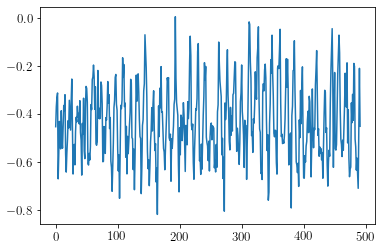

In [10]:
plt.figure()
plt.plot(w.slp40S[:] - w2.slp40S[:])

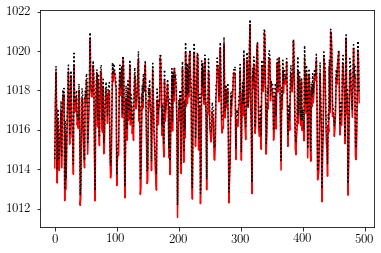

In [11]:
w

plt.figure()
# plt.plot(w.slp65S[:], linestyle = '-', color = 'r')
# plt.plot(w2.slp65S[:], linestyle = ':', color = 'k')

plt.plot(w.slp40S[:], linestyle = '-', color = 'r')
plt.plot(w2.slp40S[:], linestyle = ':', color = 'k')

## get sam

UKESMm1
UKESMm2
UKESMm3
UKESM-NOm1
UKESM-NOm2
UKESM-NOm3


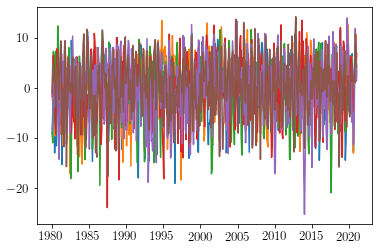

In [13]:
ex = True
nors = ['1B','1BM2','1BM3','2B','2BM2','2BM3',]

if ex:
    


    for nor in nors:
        
        prod = m3dict[nor]['wts']
        print(prod)
        
        w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SLP.nc')



        slp40S_a = w.slp40S - w.slp40S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

        slp65S_a = w.slp65S - w.slp65S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

        plt.plot(w.time,slp40S_a-slp65S_a, label = prod)
        SAM = slp40S_a-slp65S_a
        w['SAM'] = (('time'), SAM)
        w.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/{prod}/SAM.nc')

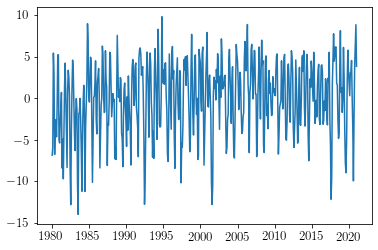

In [14]:
ex = True
        
w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMEM/SLP.nc')

slp40S_a = w.slp40S - w.slp40S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

slp65S_a = w.slp65S - w.slp65S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

plt.plot(w.time,slp40S_a-slp65S_a, label = prod)
SAM = slp40S_a-slp65S_a
w['SAM'] = (('time'), SAM)
w.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMEM/SAM.nc')

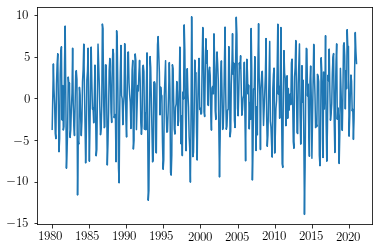

In [15]:
ex = True
        
w = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMEM-NO/SLP.nc')

slp40S_a = w.slp40S - w.slp40S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

slp65S_a = w.slp65S - w.slp65S.sel(time=slice('1980-01-01', '2019-12-31')).mean()

plt.plot(w.time,slp40S_a-slp65S_a, label = prod)
SAM = slp40S_a-slp65S_a
w['SAM'] = (('time'), SAM)
w.to_netcdf(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMEM-NO/SAM.nc')

## how different is ukesmem and mean of ukesm m1 m2 m3 

reassuringly similar.


In [21]:
ukem = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMEM/SAM.nc')
ukm1 = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMm1/SAM.nc')
ukm2 = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMm2/SAM.nc')
ukm3 = xr.open_dataset(f'/gpfs/data/greenocean2/software/products/windsFromComponents/SAM/UKESMm3/SAM.nc')
ukmn = (ukm1.SAM + ukm2.SAM + ukm3.SAM)/3

In [20]:
ukmn = (ukm1.SAM + ukm2.SAM + ukm3.SAM)/3

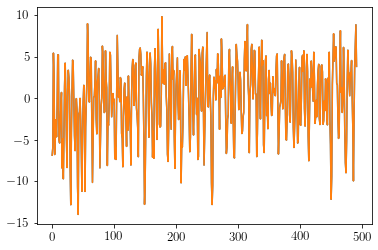

In [25]:
plt.figure()
plt.plot(ukem.SAM)
plt.plot(ukmn)

(-0.001, 0.001)

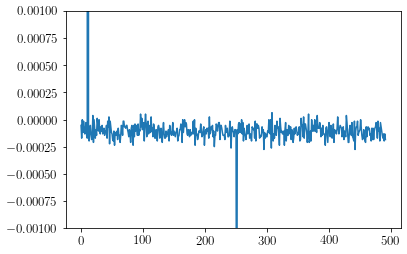

In [28]:
plt.figure()
plt.plot(ukem.SAM- ukmn)
tlim = 0.001
plt.ylim([-1*tlim,tlim])